In [93]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Data Collection

In [94]:
# Path ke file CSV
path1 = "logs_CPI1H3-IF-47-01PJJ_KALKULUSLANJUT_DNS_2324_2.csv"
path2 = "logs_CPI1F4-IF-47-GAB.1PJJ_ALPRO_DRI_2324_2.csv"

datapath = path2 
df = pd.read_csv(datapath, delimiter=';', on_bad_lines='skip')

print(df.shape)
df.head()

(12291, 1)


,"Time,Hour,User full name,Affected user,Event context,Component,Event name,Description,Origin,IP address"
0,"29/08/24, 22:34,FAISAL RAMADHANI,-,Course: ALG..."
1,"29/08/24, 20:53,MUHAMMAD FATHAN YUSRIZAL,-,Cou..."
2,"27/08/24, 13:28,RAZZAQI NURRADITHYA SASTROPRAW..."
3,"27/08/24, 13:28,RAZZAQI NURRADITHYA SASTROPRAW..."
4,"19/08/24, 19:34,ZHAFIR RASYID MUHAMMAD HAFIDZ,..."


## Data Pre-processing

Fixing Dataset

In [95]:
# Langkah 1: Baca raw file
with open(datapath, 'r', encoding='utf-8') as f:
    raw_data = f.read()

# Langkah 2: Bersihkan tanda kutip ganda dan karakter akhir seperti ;"
cleaned_data = raw_data.replace('""', '"').replace('\ufeff', '')
lines = cleaned_data.strip().splitlines()

# Langkah 3: Bersihkan tiap baris
cleaned_lines = []
for line in lines:
    if line.endswith('";'):
        line = line[:-2]  # Hapus ;" di akhir
    if line.startswith('"') and line.endswith('"'):
        line = line[1:-1]  # Hapus tanda kutip luar
    cleaned_lines.append(line)

# Langkah 4: Parsing manual untuk pisahkan kolom Date dan Time
processed_rows = []

for line in cleaned_lines:
    if not line.strip():
        continue
    if line.startswith('"') and line.endswith('"'):
        line = line[1:-1]

    try:
        # Pisahkan date dan time
        date_part, rest = line.split(',', maxsplit=1)
        time_part, rest = rest.split(',', maxsplit=1)

        # Gunakan csv.reader untuk parsing kolom selanjutnya
        parsed_rest = next(csv.reader([rest], delimiter=',', quotechar='"'))
        parsed_row = [date_part.strip('"'), time_part.strip()] + parsed_rest
        processed_rows.append(parsed_row)
    except Exception as e:
        print("Baris gagal diproses:", line)
        print("Error:", e)

# Langkah 5: Definisikan nama kolom
columns = ['Date', 'Time', 'User full name', 'Affected user', 'Event context',
           'Component', 'Event name', 'Description', 'Origin', 'IP address']

# Langkah 6: Buat DataFrame
df = pd.DataFrame(processed_rows[1:], columns=columns)  # [1:] karena baris pertama adalah header duplikat

# Atur agar index dimulai dari 1
df.index = df.index + 1

# Tampilkan hasil
print("Daftar Kolom:\n", df.columns.tolist())

def show_table(df, max_rows=20, max_cols=10, max_height=400):
    html = df.to_html(
        max_rows=max_rows,
        max_cols=max_cols,
        border=0,
        justify='center',
        escape=False
    ).replace(
        '<table',
        f'<div style="overflow:auto; max-height:{max_height}px;"><table style="width:auto; border-collapse: collapse;"'
    ).replace(
        '</table>',
        '</table></div>'
    )
    display(HTML(html))

display(HTML(f"<b>{datapath}</b> - Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}"))
show_table(df)

Daftar Kolom:
 ['Date', 'Time', 'User full name', 'Affected user', 'Event context', 'Component', 'Event name', 'Description', 'Origin', 'IP address']


,Date,Time,User full name,Affected user,Event context,Component,Event name,Description,Origin,IP address
1,29/08/24,22:34,FAISAL RAMADHANI,-,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '76232' viewed the course with id '42539'.,web,111.68.123.3
2,29/08/24,20:53,MUHAMMAD FATHAN YUSRIZAL,-,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '65137' viewed the course with id '42539'.,web,182.3.8.218
3,27/08/24,13:28,RAZZAQI NURRADITHYA SASTROPRAWIRO,-,Assignment: [CLO-3] Tugas Kelompok Pekan 9-11: Searching,Assignment,The status of the submission has been viewed.,The user with id '64714' has viewed the submission status page for the assignment with course module id '3883224'.,web,114.79.54.13
4,27/08/24,13:28,RAZZAQI NURRADITHYA SASTROPRAWIRO,-,Assignment: [CLO-3] Tugas Kelompok Pekan 9-11: Searching,Assignment,Course module viewed,The user with id '64714' viewed the 'assign' activity with course module id '3883224'.,web,114.79.54.13
5,19/08/24,19:34,ZHAFIR RASYID MUHAMMAD HAFIDZ,-,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '76910' viewed the course with id '42539'.,web,140.213.138.238
6,31/07/24,21:04,AGUNG SRI DARMA,-,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.,web,114.122.37.13
7,31/07/24,06:41,AGUNG SRI DARMA,-,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.,web,114.122.40.137
8,31/07/24,06:41,AGUNG SRI DARMA,-,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.,web,114.122.40.137
9,30/07/24,16:31,AGUNG SRI DARMA,-,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.,web,114.122.42.251
10,30/07/24,14:09,AGUNG SRI DARMA,-,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.,web,114.122.39.85


Merge Date & Time

In [96]:
# Gabungkan kolom Date dan Time menjadi Timestamp
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%y %H:%M', errors='coerce')
df = df[['Timestamp'] + [col for col in df.columns if col != 'Timestamp']]

# Hapus kolom Date dan Time serta kolom yang tidak diperlukan
df.drop(columns=['Date', 'Time', 'Affected user', 'Origin', 'IP address'], inplace=True)

display(HTML(f"<b>{datapath}</b> - Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}"))
show_table(df)

,Timestamp,User full name,Event context,Component,Event name,Description
1,2024-08-29 22:34:00,FAISAL RAMADHANI,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '76232' viewed the course with id '42539'.
2,2024-08-29 20:53:00,MUHAMMAD FATHAN YUSRIZAL,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '65137' viewed the course with id '42539'.
3,2024-08-27 13:28:00,RAZZAQI NURRADITHYA SASTROPRAWIRO,Assignment: [CLO-3] Tugas Kelompok Pekan 9-11: Searching,Assignment,The status of the submission has been viewed.,The user with id '64714' has viewed the submission status page for the assignment with course module id '3883224'.
4,2024-08-27 13:28:00,RAZZAQI NURRADITHYA SASTROPRAWIRO,Assignment: [CLO-3] Tugas Kelompok Pekan 9-11: Searching,Assignment,Course module viewed,The user with id '64714' viewed the 'assign' activity with course module id '3883224'.
5,2024-08-19 19:34:00,ZHAFIR RASYID MUHAMMAD HAFIDZ,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '76910' viewed the course with id '42539'.
6,2024-07-31 21:04:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
7,2024-07-31 06:41:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
8,2024-07-31 06:41:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
9,2024-07-30 16:31:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
10,2024-07-30 14:09:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.


Pengecekan Mahasiswa (Sesuai PDF Nilai)

In [97]:
# Daftar nama mahasiswa 
nama_mahasiswa_alpro = [
    "KHRISNA RADITYA HUSODO", "ALDRICH MATTHEW LIKAJA", "FAISAL RAMADHANI", "DWIYANA TRI PANDAYA",
    "CARISSA AZMI ANANTA", "IRSYAD FADHILAH", "RIFKI SEPTIADI EPENDI", "MUHAMMAD RAFI",
    "ZHAFIR RASYID MUHAMMAD HAFIDZ", "ANISA MUTIASARI", "DIAN NA'ILAH SALIMAH", "NURHASANAH NURHASANAH",
    "MOHHAMMAD AGUSTIAN SUPARMAN", "YEHUDA DOSOLOGIA AZER KOIREWOA", "AGUNG SRI DARMA",
    "RAHMATULLAH JOESA PUTRA", "MUHAMMAD FATHAN YUSRIZAL", "EKO WIDODO", "HENDRA RIZQI ALFARIZY",
    "JOSHAFAT MIGUEL MARULI HUTAPEA", "RAZZAQI NURRADITHYA SASTROPRAWIRO",
    "HERMAWAN HERMAWAN", "FIRA AULIA RAMADHANI", "DZAKWAN WAFA KHAIRAWAN", "DESTY ARYANTI"
]
nama_mahasiswa_alpro.sort()

# Normalisasi kolom User full name ke huruf besar
usernames_in_log = df["User full name"].str.upper().unique().tolist()

# Cek siapa saja yang ada dan siapa yang tidak ada
nama_ditemukan = []
nama_tidak_ditemukan = []

for nama in nama_mahasiswa_alpro:
    if nama.upper() in usernames_in_log:
        nama_ditemukan.append(nama)
    else:
        nama_tidak_ditemukan.append(nama)

# Tampilkan hasil
print("✅ Nama ditemukan di log ({}):\n".format(len(nama_ditemukan)), "\n". join(nama_ditemukan))
print("\n❌ Nama tidak ditemukan di log ({}):\n".format(len(nama_tidak_ditemukan)), "\n".join(nama_tidak_ditemukan))

✅ Nama ditemukan di log (24):
 AGUNG SRI DARMA
ALDRICH MATTHEW LIKAJA
ANISA MUTIASARI
CARISSA AZMI ANANTA
DESTY ARYANTI
DIAN NA'ILAH SALIMAH
DWIYANA TRI PANDAYA
EKO WIDODO
FAISAL RAMADHANI
FIRA AULIA RAMADHANI
HENDRA RIZQI ALFARIZY
HERMAWAN HERMAWAN
IRSYAD FADHILAH
JOSHAFAT MIGUEL MARULI HUTAPEA
KHRISNA RADITYA HUSODO
MOHHAMMAD AGUSTIAN SUPARMAN
MUHAMMAD FATHAN YUSRIZAL
MUHAMMAD RAFI
NURHASANAH NURHASANAH
RAHMATULLAH JOESA PUTRA
RAZZAQI NURRADITHYA SASTROPRAWIRO
RIFKI SEPTIADI EPENDI
YEHUDA DOSOLOGIA AZER KOIREWOA
ZHAFIR RASYID MUHAMMAD HAFIDZ

❌ Nama tidak ditemukan di log (1):
 DZAKWAN WAFA KHAIRAWAN


Menghapus Nama yang bukan termasuk Mahasiswa

In [98]:
uniq_name_unfiltered = df["User full name"].unique()
print(np.sort(uniq_name_unfiltered))
print("\nTotal nama unik sebelum difilter:", len(uniq_name_unfiltered), "\n")
print("====================================================================")

exclude_names = [
    'DONNI RICHASDY', # Dosen Matakuliah Alpro

    'MARCEL BINGGI ANTONIO TOBING', #Bukan Mahasiswa Matakuliah Alpro #Dzakwan
    
    '-',
    'Admin CELOE',
    'System',
    'System CeLOE 01',
    'System CeLOE 02',
    'Sarjana (S1) PJJ Informatika Telkom University',
    'WS User',
    "Course module updated"
]

# Filter dataframe
df = df[~df["User full name"].isin(exclude_names)]

# Cek hasil unique names setelah filtering
uniq_name_filtered = df["User full name"].unique()
print(np.sort(uniq_name_filtered))
print("\nTotal nama unik setelah difilter:", len(uniq_name_filtered))

['-' 'AGUNG SRI DARMA' 'ALDRICH MATTHEW LIKAJA' 'ANISA MUTIASARI'
 'CARISSA AZMI ANANTA' 'Course module updated' 'DESTY ARYANTI'
 "DIAN NA'ILAH SALIMAH" 'DONNI RICHASDY' 'DWIYANA TRI PANDAYA'
 'EKO WIDODO' 'FAISAL RAMADHANI' 'FIRA AULIA RAMADHANI'
 'HENDRA RIZQI ALFARIZY' 'HERMAWAN HERMAWAN' 'IRSYAD FADHILAH'
 'JOSHAFAT MIGUEL MARULI HUTAPEA' 'KHRISNA RADITYA HUSODO'
 'MARCEL BINGGI ANTONIO TOBING' 'MOHHAMMAD AGUSTIAN SUPARMAN'
 'MUHAMMAD FATHAN YUSRIZAL' 'MUHAMMAD RAFI' 'NURHASANAH NURHASANAH'
 'RAHMATULLAH JOESA PUTRA' 'RAZZAQI NURRADITHYA SASTROPRAWIRO'
 'RIFKI SEPTIADI EPENDI' 'Sarjana (S1) PJJ Informatika Telkom University'
 'System' 'System CeLOE 01' 'WS User' 'YEHUDA DOSOLOGIA AZER KOIREWOA'
 'ZHAFIR RASYID MUHAMMAD HAFIDZ']

Total nama unik sebelum difilter: 32 

['AGUNG SRI DARMA' 'ALDRICH MATTHEW LIKAJA' 'ANISA MUTIASARI'
 'CARISSA AZMI ANANTA' 'DESTY ARYANTI' "DIAN NA'ILAH SALIMAH"
 'DWIYANA TRI PANDAYA' 'EKO WIDODO' 'FAISAL RAMADHANI'
 'FIRA AULIA RAMADHANI' 'HENDRA RIZQI A

In [99]:
display(HTML(f"<b>{datapath}</b> - Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}"))
show_table(df)

,Timestamp,User full name,Event context,Component,Event name,Description
1,2024-08-29 22:34:00,FAISAL RAMADHANI,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '76232' viewed the course with id '42539'.
2,2024-08-29 20:53:00,MUHAMMAD FATHAN YUSRIZAL,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '65137' viewed the course with id '42539'.
3,2024-08-27 13:28:00,RAZZAQI NURRADITHYA SASTROPRAWIRO,Assignment: [CLO-3] Tugas Kelompok Pekan 9-11: Searching,Assignment,The status of the submission has been viewed.,The user with id '64714' has viewed the submission status page for the assignment with course module id '3883224'.
4,2024-08-27 13:28:00,RAZZAQI NURRADITHYA SASTROPRAWIRO,Assignment: [CLO-3] Tugas Kelompok Pekan 9-11: Searching,Assignment,Course module viewed,The user with id '64714' viewed the 'assign' activity with course module id '3883224'.
5,2024-08-19 19:34:00,ZHAFIR RASYID MUHAMMAD HAFIDZ,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '76910' viewed the course with id '42539'.
6,2024-07-31 21:04:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
7,2024-07-31 06:41:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
8,2024-07-31 06:41:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
9,2024-07-30 16:31:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
10,2024-07-30 14:09:00,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.


In [100]:
# Mengganti User full name dengan User ID
df["User ID"] = df.groupby("User full name").ngroup() + 1

cols = ['User ID'] + [col for col in df.columns if col != 'User ID']
df = df[cols]

user_id_col = df.pop('User ID')  
df.insert(1, 'User ID', user_id_col)

In [101]:
column_widths = {
    'User ID': '50px'  # Lebar kolom User ID dapat disesuaikan sesuai kebutuhan
}

# Membuat fungsi untuk menambahkan lebar kolom pada tag <th>
def show_table(df, column_widths):
    table_html = df.to_html(
        max_rows=20,
        max_cols=10,
        border=0,
        justify='center',
        escape=False
    )

    # Menambahkan lebar kolom berdasarkan dictionary column_widths
    for col, width in column_widths.items():
        table_html = table_html.replace(f'<th>{col}</th>', f'<th style="width: {width};">{col}</th>')

    # Membungkus table dengan div untuk overflow
    table_html = table_html.replace(
        '<table',
        '<div style="overflow:auto; max-height:400px;"><table style="width:auto; border-collapse: collapse;"'
    ).replace(
        '</table>',
        '</table></div>'
    )
    
    return table_html

# Apply column width to the 'User ID' column
table_html = show_table(df, column_widths)

# Display the table with the adjusted width
display(HTML(f"<b>{datapath}</b> - Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}"))
display(HTML(table_html))

,Timestamp,User ID,User full name,Event context,Component,Event name,Description
1,2024-08-29 22:34:00,9,FAISAL RAMADHANI,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '76232' viewed the course with id '42539'.
2,2024-08-29 20:53:00,17,MUHAMMAD FATHAN YUSRIZAL,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '65137' viewed the course with id '42539'.
3,2024-08-27 13:28:00,21,RAZZAQI NURRADITHYA SASTROPRAWIRO,Assignment: [CLO-3] Tugas Kelompok Pekan 9-11: Searching,Assignment,The status of the submission has been viewed.,The user with id '64714' has viewed the submission status page for the assignment with course module id '3883224'.
4,2024-08-27 13:28:00,21,RAZZAQI NURRADITHYA SASTROPRAWIRO,Assignment: [CLO-3] Tugas Kelompok Pekan 9-11: Searching,Assignment,Course module viewed,The user with id '64714' viewed the 'assign' activity with course module id '3883224'.
5,2024-08-19 19:34:00,24,ZHAFIR RASYID MUHAMMAD HAFIDZ,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '76910' viewed the course with id '42539'.
6,2024-07-31 21:04:00,1,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
7,2024-07-31 06:41:00,1,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
8,2024-07-31 06:41:00,1,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
9,2024-07-30 16:31:00,1,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.
10,2024-07-30 14:09:00,1,AGUNG SRI DARMA,Course: ALGORITMA PEMROGRAMAN IF-47-GAB.1PJJ [DRI],System,Course viewed,The user with id '63541' viewed the course with id '42539'.


In [102]:
print(df['Component'].unique())
print("\n")
print(df['Event name'].sort_values().unique())

['System' 'Assignment' 'User report' 'Quiz' 'File submissions' 'Forum'
 'URL' 'Overview report' 'File' 'Page' 'Submission comments']


['A file has been uploaded.' 'A submission has been submitted.'
 'Badge listing viewed' 'Comment created'
 'Course activity completion updated' 'Course module instance list viewed'
 'Course module viewed' 'Course user report viewed' 'Course viewed'
 'Discussion created' 'Discussion deleted' 'Discussion viewed'
 'Feedback viewed' 'Grade item updated' 'Grade overview report viewed'
 'Grade user report viewed' 'Post created' 'Post deleted' 'Post updated'
 'Quiz attempt reviewed' 'Quiz attempt started' 'Quiz attempt submitted'
 'Quiz attempt summary viewed' 'Quiz attempt viewed'
 'Some content has been posted.' 'Submission created.'
 'Submission form viewed.' 'Submission updated.'
 'The status of the submission has been viewed.' 'User graded'
 'User list viewed' 'User profile viewed']


In [103]:
for component, group in df.groupby('Component'):
    print(f"Component: {component}")
    print(group['Event name'].unique())
    print("\n")

Component: Assignment
['The status of the submission has been viewed.' 'Course module viewed'
 'Feedback viewed' 'A submission has been submitted.'
 'Submission form viewed.']


Component: File
['Course module viewed']


Component: File submissions
['Submission created.' 'A file has been uploaded.' 'Submission updated.']


Component: Forum
['Discussion viewed' 'Course module viewed' 'Discussion created'
 'Some content has been posted.' 'Post created' 'Discussion deleted'
 'Post deleted' 'Course module instance list viewed' 'Post updated']


Component: Overview report
['Grade overview report viewed']


Component: Page
['Course module viewed']


Component: Quiz
['Course module viewed' 'Quiz attempt viewed' 'Quiz attempt reviewed'
 'Quiz attempt submitted' 'Quiz attempt summary viewed'
 'Quiz attempt started']


Component: Submission comments
['Comment created']


Component: System
['Course viewed' 'User list viewed' 'Course activity completion updated'
 'User profile viewed' 'Badge listi

In [104]:
for component, group in df.groupby('Component'):
    print(f"Component: {component}")
    
    # Ambil kombinasi unik Event name dan Event context
    unique_combinations = group[['Event name', 'Event context']].drop_duplicates()
    
    print(unique_combinations)
    print("\n")

Component: Assignment
                                         Event name  \
3     The status of the submission has been viewed.   
4                              Course module viewed   
20                                  Feedback viewed   
67                 A submission has been submitted.   
72                          Submission form viewed.   
77    The status of the submission has been viewed.   
78                             Course module viewed   
79                 A submission has been submitted.   
83                          Submission form viewed.   
168                                 Feedback viewed   
3931  The status of the submission has been viewed.   
3932                           Course module viewed   
4192  The status of the submission has been viewed.   
4193                           Course module viewed   
4229  The status of the submission has been viewed.   
4230                           Course module viewed   
4510  The status of the submission has been

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7570 entries, 1 to 10646
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       7570 non-null   datetime64[ns]
 1   User ID         7570 non-null   int64         
 2   User full name  7570 non-null   object        
 3   Event context   7570 non-null   object        
 4   Component       7570 non-null   object        
 5   Event name      7570 non-null   object        
 6   Description     7570 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 473.1+ KB


## Feature Engineering

### Fix Index

In [106]:
df.info()
print("=======================")
df = df.reset_index(drop=True)
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 7570 entries, 1 to 10646
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       7570 non-null   datetime64[ns]
 1   User ID         7570 non-null   int64         
 2   User full name  7570 non-null   object        
 3   Event context   7570 non-null   object        
 4   Component       7570 non-null   object        
 5   Event name      7570 non-null   object        
 6   Description     7570 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 473.1+ KB


Timestamp         0
User ID           0
User full name    0
Event context     0
Component         0
Event name        0
Description       0
dtype: int64

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       7570 non-null   datetime64[ns]
 1   User ID         7570 non-null   int64         
 2   User full name  7570 non-null   object        
 3   Event context   7570 non-null   object        
 4   Component       7570 non-null   object        
 5   Event name      7570 non-null   object        
 6   Description     7570 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 414.1+ KB


### Extract Week and Year Components

In [108]:
df['week'] = df['Timestamp'].dt.isocalendar().week
df['year'] = df['Timestamp'].dt.year

display(df['year'].value_counts())
display(df['week'].unique())

year
2024    7570
Name: count, dtype: int64

<IntegerArray>
[35, 34, 31, 30, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,
 13, 12, 11, 10,  9,  8,  7]
Length: 26, dtype: UInt32

### content_accessed

In [109]:
# Dapatkan semua unique User ID dari dataset asli
all_user_ids = df["User ID"].unique()

# Filter data berdasarkan Component yang relevan
content_data = df[df["Component"].isin(["URL", "File", "H5P"])].copy()

# Tambahkan kolom week dan year untuk grouping
content_data["week"] = content_data["Timestamp"].dt.isocalendar().week
content_data["year"] = content_data["Timestamp"].dt.isocalendar().year

# Hitung total content accessed per user per week per component
weekly_content = (
    content_data.groupby(["User ID", "week", "year", "Component"])
    .size()
    .reset_index(name="count")
)

# Pivot untuk mendapatkan kolom terpisah untuk setiap component
weekly_content_pivot = weekly_content.pivot_table(
    index=["User ID", "week", "year"], columns="Component", values="count", fill_value=0
).reset_index()

# Hitung total content accessed per user per week
weekly_content_pivot["total_content_weekly"] = (
    weekly_content_pivot.get("File", 0)
    + weekly_content_pivot.get("URL", 0)
    + weekly_content_pivot.get("H5P", 0)
)

# Hitung rata-rata content accessed per week untuk setiap user
mean_content_accessed_per_week = (
    weekly_content_pivot.groupby("User ID")["total_content_weekly"]
    .mean()
    .rename("mean_content_accessed_per_week")
)

# Reindex untuk memastikan semua user ID ada
mean_content_accessed_per_week = mean_content_accessed_per_week.reindex(
    all_user_ids, fill_value=0
).round(4)

print("Mean Content Accessed Per Week:")
print(mean_content_accessed_per_week.sort_index())  


Mean Content Accessed Per Week:
User ID
1     0.0000
2     3.3750
3     0.0000
4     1.5000
5     2.6667
6     4.5000
7     5.4000
8     5.3000
9     2.5000
10    4.5000
11    2.0000
12    5.2000
13    2.0000
14    1.0000
15    7.0000
16    1.0000
17    2.0000
18    2.0000
19    3.0000
20    0.0000
21    1.6250
22    0.0000
23    3.0000
24    6.6667
Name: mean_content_accessed_per_week, dtype: float64


### forum_activity

In [110]:
# Dapatkan semua unique User ID dari dataset asli
all_user_ids = df["User ID"].unique()

# Filter data berdasarkan Event name yang relevan untuk forum activity
forum_data = df[df["Event name"].isin(["Discussion viewed", "Post created", "Some content has been posted."])].copy()

# Tambahkan kolom week dan year untuk grouping
forum_data['week'] = forum_data['Timestamp'].dt.isocalendar().week
forum_data['year'] = forum_data['Timestamp'].dt.isocalendar().year

# Hitung total forum activity per user per week per event
weekly_forum = (
    forum_data.groupby(['User ID', 'week', 'year', 'Event name'])
    .size()
    .reset_index(name='count')
)

# Pivot untuk mendapatkan kolom terpisah untuk setiap event
weekly_forum_pivot = (
    weekly_forum.pivot_table(
        index=['User ID', 'week', 'year'],
        columns='Event name',
        values='count',
        fill_value=0
    )
    .reset_index()
)

# Hitung total forum activity per user per week
weekly_forum_pivot['total_forum_weekly'] = (
    weekly_forum_pivot.get('Post created', 0) + 
    weekly_forum_pivot.get('Discussion viewed', 0) +
    + weekly_forum_pivot.get('Some content has been posted.', 0)
)

# Hitung rata-rata forum activity per week untuk setiap user
mean_forum_activity_per_week = (
    weekly_forum_pivot.groupby('User ID')['total_forum_weekly']
    .mean()
    .rename('mean_forum_activity_per_week')
)

# Reindex untuk memastikan semua user ID ada
mean_forum_activity_per_week = mean_forum_activity_per_week.reindex(all_user_ids, fill_value=0).round(4)

print("Mean Forum Activity Per Week:")
print(mean_forum_activity_per_week.sort_index())

Mean Forum Activity Per Week:
User ID
1      3.0000
2      3.5000
3      2.0000
4      4.0000
5      0.0000
6     17.0000
7      3.6667
8      4.3333
9      2.0000
10     5.3333
11     3.5000
12     4.2000
13     0.0000
14     2.2857
15     5.0000
16     2.5000
17     1.5000
18     7.0000
19     0.0000
20     0.0000
21     3.7500
22     4.0000
23     1.0000
24     4.5000
Name: mean_forum_activity_per_week, dtype: float64


### assignment_completed

In [111]:
# Dapatkan semua unique User ID dari dataset asli
all_user_ids = df["User ID"].unique()

# Filter data berdasarkan Event name yang relevan untuk forum activity
assignment_data = df[
    df["Event name"].isin(
        [
            "A submission has been submitted.",
            "Submission created.",
            "A file has been uploaded.",
        ]
    )
].copy()

# Tambahkan kolom week dan year untuk grouping
assignment_data["week"] = assignment_data["Timestamp"].dt.isocalendar().week
assignment_data["year"] = assignment_data["Timestamp"].dt.isocalendar().year

# Hitung total forum activity per user per week per event
weekly_assignment = (
    assignment_data.groupby(["User ID", "week", "year", "Event name"])
    .size()
    .reset_index(name="count")
)

# Pivot untuk mendapatkan kolom terpisah untuk setiap event
weekly_assignment_pivot = weekly_assignment.pivot_table(
    index=["User ID", "week", "year"],
    columns="Event name",
    values="count",
    fill_value=0,
).reset_index()

# Hitung total forum activity per user per week
weekly_assignment_pivot["total_assignment_weekly"] = (
    weekly_assignment_pivot.get("A submission has been submitted.", 0)
    + weekly_assignment_pivot.get("Submission created.", 0)
    + +weekly_assignment_pivot.get("A file has been uploaded.", 0)
)

# Hitung rata-rata forum activity per week untuk setiap user
mean_weekly_assignment_per_week = (
    weekly_assignment_pivot.groupby("User ID")["total_assignment_weekly"]
    .mean()
    .rename("mean_weekly_assignment_per_week")
)

# Reindex untuk memastikan semua user ID ada
mean_weekly_assignment_per_week = mean_weekly_assignment_per_week.reindex(
    all_user_ids, fill_value=0
).round(4)

print("Mean Forum Activity Per Week:")
print(mean_weekly_assignment_per_week.sort_index())


Mean Forum Activity Per Week:
User ID
1     3.00
2     3.00
3     0.00
4     0.00
5     0.00
6     0.00
7     3.00
8     3.00
9     3.00
10    3.00
11    0.00
12    3.00
13    0.00
14    4.50
15    0.00
16    0.00
17    3.00
18    0.00
19    0.00
20    0.00
21    4.25
22    3.00
23    0.00
24    0.00
Name: mean_weekly_assignment_per_week, dtype: float64


### mean_quiz

In [112]:
quiz_only = df[
    df["Event name"].isin(["Quiz attempt submitted", "Quiz attempt started"])
].sort_values(by=["User ID", "Timestamp"])


# Membuat fitur quiz_time
def calculate_quiz_time(group):
    """
    Menghitung waktu quiz untuk setiap user
    """
    # Reset index untuk memudahkan indexing
    group = group.reset_index(drop=True)

    # Mencari pasangan start dan submit untuk setiap attempt
    quiz_times = []

    i = 0
    while i < len(group) - 1:
        # Cari quiz attempt started
        if group.loc[i, "Event name"] == "Quiz attempt started":
            # Cari quiz attempt submitted berikutnya
            j = i + 1
            while j < len(group):
                if group.loc[j, "Event name"] == "Quiz attempt submitted":
                    # Hitung selisih waktu
                    start_time = pd.to_datetime(group.loc[i, "Timestamp"])
                    submit_time = pd.to_datetime(group.loc[j, "Timestamp"])
                    quiz_time = submit_time - start_time

                    # Tambahkan informasi quiz time ke row submit
                    quiz_times.append(
                        {
                            "User ID": group.loc[j, "User ID"],
                            "Timestamp": group.loc[j, "Timestamp"],
                            "Event name": group.loc[j, "Event name"],
                            "quiz_time": quiz_time,
                            "quiz_time_minutes": quiz_time.total_seconds() / 60,
                        }
                    )
                    break
                j += 1
        i += 1

    return pd.DataFrame(quiz_times)


# Terapkan fungsi untuk setiap user
quiz_time_weekly = (
    quiz_only.groupby("User ID", group_keys=False)
             .apply(calculate_quiz_time)
             .reset_index(drop=True)
)


quiz_time_weekly['User ID'] = quiz_time_weekly['User ID'].astype(int)

C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_48692\3891428092.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_quiz_time)


Ada 7 data quiz time anomali, harus di drop

In [113]:
quiz_time_weekly["quiz_time_minutes"].sort_values(ascending=False).head(10)

138    113994.0
120     63091.0
121     43884.0
122     36618.0
39      26125.0
139     24648.0
99      23082.0
6       18788.0
36      18401.0
25      17630.0
Name: quiz_time_minutes, dtype: float64

In [114]:
quiz_time_weekly = quiz_time_weekly.query("quiz_time_minutes < 150")
quiz_time_weekly['quiz_time_minutes'].describe()

count     97.000000
mean      35.608247
std       34.364637
min        0.000000
25%        9.000000
50%       27.000000
75%       41.000000
max      149.000000
Name: quiz_time_minutes, dtype: float64

In [115]:
quiz_time_weekly['week'] = quiz_time_weekly['Timestamp'].dt.isocalendar().week
quiz_time_weekly['year'] = quiz_time_weekly['Timestamp'].dt.isocalendar().year

weekly_quiz_dur = quiz_time_weekly.groupby(['User ID', 'week', 'year'])['quiz_time_minutes'].mean().reset_index(name='avg_quiz_time_minutes')
display(weekly_quiz_dur.head(30))

mean_quiz_week = (
    weekly_quiz_dur.groupby("User ID")["avg_quiz_time_minutes"]
    .mean()
    .rename("weekly_mean_quiz")  # ← kolom 3
).round(4)
display(mean_quiz_week.sort_index())

,User ID,week,year,avg_quiz_time_minutes
0,1,10,2024,3.000000
1,1,11,2024,33.000000
2,1,14,2024,5.000000
3,1,15,2024,0.333333
4,1,17,2024,27.000000
5,1,20,2024,28.500000
6,1,21,2024,2.000000
7,1,22,2024,5.000000
8,1,24,2024,26.000000
9,2,9,2024,40.000000


User ID
1      14.4259
2      55.6000
4      21.5000
6      24.2000
7      42.8333
8      41.7500
9      59.6667
11    102.3333
12     33.0000
14     15.0833
16     23.6000
17     33.7500
20      8.0000
21     62.1875
22     31.5000
24     26.0000
Name: weekly_mean_quiz, dtype: float64

### mean_dur_week

In [116]:
# Sort value berdasarkan User ID dan Timestamp agar session urut
df = (
    df.sort_values(["User ID", "Timestamp"])
      .drop_duplicates(subset=["User ID", "Timestamp"], keep="first")
      .reset_index(drop=True)
)
df = df.sort_values(["User ID", "Timestamp"])

# Menghitung gap antar sesi untuk menentukan sesi baru / tidak
df["prev_time"] = df.groupby("User ID")["Timestamp"].shift()
df["gap_min"]   = (df["Timestamp"] - df["prev_time"]).dt.total_seconds() / 60

# Digunakan threshold 120 menit untuk menentukan sesi baru / tidak, 
# apabila gap_menit > 120 menit, maka sesi baru
SESSION_GAP = 45 # menit

df["new_session"] = (df["gap_min"].isna()) | (df["gap_min"] >= SESSION_GAP)
df["session_id"] = df.groupby("User ID")["new_session"].cumsum()

df[['session_id', 'Timestamp', 'prev_time', 'gap_min', 'new_session']].head(20)

,session_id,Timestamp,prev_time,gap_min,new_session
0,1,2024-03-03 19:44:00,NaT,NaN,True
1,2,2024-03-03 20:46:00,2024-03-03 19:44:00,62.0,True
2,3,2024-03-04 16:18:00,2024-03-03 20:46:00,1172.0,True
3,3,2024-03-04 16:24:00,2024-03-04 16:18:00,6.0,False
4,4,2024-03-04 19:58:00,2024-03-04 16:24:00,214.0,True
5,4,2024-03-04 19:59:00,2024-03-04 19:58:00,1.0,False
6,4,2024-03-04 20:03:00,2024-03-04 19:59:00,4.0,False
7,4,2024-03-04 20:04:00,2024-03-04 20:03:00,1.0,False
8,4,2024-03-04 20:05:00,2024-03-04 20:04:00,1.0,False
9,4,2024-03-04 20:06:00,2024-03-04 20:05:00,1.0,False


In [117]:
# Mengelompokkan sesi berdasarkan User ID dan session_id
# Digunakan untuk menghitung durasi sesi 
session_span = (
    df.groupby(["User ID", "session_id"])
      .agg(session_start=("Timestamp", "min"),
           session_end  =("Timestamp", "max"),
           hits         =("Timestamp", "count"))
      .reset_index()
)

# Menghitung durasi sesi
session_span["session_dur"] = (
    session_span["session_end"] - session_span["session_start"]
).dt.total_seconds() / 60   # menit

# Mengatur durasi sesi yang tidak masuk kategori 1 - 45 menit menjadi 1 menit
# Digunakan untuk mengatasi sesi tidak masuk akal
# Seperti 1000 Menit, dikarenakan jeda antar sesi / akses
session_span.loc[(session_span["session_dur"] > 45) | (session_span["session_dur"] < 1), "session_dur"] = 1

session_span["week"] = session_span["session_start"].dt.isocalendar().week
session_span["year"] = session_span["session_start"].dt.year

display(session_span.head(20))
session_span['session_dur'].describe()

,User ID,session_id,session_start,session_end,hits,session_dur,week,year
0,1,1,2024-03-03 19:44:00,2024-03-03 19:44:00,1,1.0,9,2024
1,1,2,2024-03-03 20:46:00,2024-03-03 20:46:00,1,1.0,9,2024
2,1,3,2024-03-04 16:18:00,2024-03-04 16:24:00,2,6.0,10,2024
3,1,4,2024-03-04 19:58:00,2024-03-04 21:12:00,22,1.0,10,2024
4,1,5,2024-03-07 18:16:00,2024-03-07 18:54:00,13,38.0,10,2024
5,1,6,2024-03-10 12:59:00,2024-03-10 13:00:00,2,1.0,10,2024
6,1,7,2024-03-14 20:07:00,2024-03-14 20:52:00,11,45.0,11,2024
7,1,8,2024-03-21 21:16:00,2024-03-21 21:18:00,3,2.0,12,2024
8,1,9,2024-03-28 16:04:00,2024-03-28 16:04:00,1,1.0,13,2024
9,1,10,2024-04-03 22:15:00,2024-04-03 22:51:00,19,36.0,14,2024


count    638.000000
mean       6.885580
std       11.065571
min        1.000000
25%        1.000000
50%        1.000000
75%        6.750000
max       45.000000
Name: session_dur, dtype: float64

In [118]:
# Menghitung total durasi sesi pada minggu tsb
weekly_dur = (
    session_span.groupby(["User ID", "week", "year"])["session_dur"]
                .sum()                                # total menit sesi pada minggu tsb
                .reset_index(name="durasi_week")
)
display(weekly_dur.head(30))

# Menghitung rata-rata durasi sesi pada minggu tsb
mean_dur_week = (
    weekly_dur.groupby("User ID")["durasi_week"]
              .mean()
              .rename("mean_durasi_perminggu")        # ← kolom 3
).round(4)
display(mean_dur_week.head(30))

,User ID,week,year,durasi_week
0,1,9,2024,2.0
1,1,10,2024,46.0
2,1,11,2024,45.0
3,1,12,2024,2.0
4,1,13,2024,1.0
5,1,14,2024,50.0
6,1,15,2024,4.0
7,1,17,2024,30.0
8,1,18,2024,1.0
9,1,19,2024,34.0


User ID
1     16.5500
2     30.8125
3      3.0000
4      1.5000
5      6.8000
6     32.2500
7     20.4000
8     35.7059
9     13.2000
10    10.1429
11    32.8000
12    30.5000
13     2.0000
14    20.0526
15    26.8000
16    15.1538
17    13.5556
18    26.5000
19     7.0000
20     9.0000
21    17.5789
22    17.8000
23     6.1000
24    18.0000
Name: mean_durasi_perminggu, dtype: float64

### mean_session_week

In [119]:
# Menghitung jumlah sesi unik pada minggu tsb
sessions_per_week = (
    df.groupby(["User ID", "week", "year"])["session_id"]
      .nunique()                           # hitung sesi unik
      .reset_index(name="sessions_week")   # → kolom baru
)
display(sessions_per_week.head(30))

# Menghitung rata-rata jumlah sesi pada minggu tsb
mean_session_week = (
    sessions_per_week
      .groupby("User ID")["sessions_week"]
      .mean()                              # rata-rata sesi/minggu
      .rename("mean_sesi_perminggu")
).round(4)
display(mean_session_week.head(50))

,User ID,week,year,sessions_week
0,1,9,2024,2
1,1,10,2024,4
2,1,11,2024,1
3,1,12,2024,1
4,1,13,2024,1
5,1,14,2024,4
6,1,15,2024,3
7,1,17,2024,2
8,1,18,2024,1
9,1,19,2024,1


User ID
1     2.7500
2     3.6250
3     1.0000
4     1.5000
5     1.2000
6     3.7500
7     3.3000
8     4.8824
9     2.7333
10    1.5714
11    3.2000
12    3.4000
13    2.0000
14    3.8947
15    2.6000
16    2.3077
17    1.8889
18    4.0000
19    1.0000
20    1.0000
21    2.8947
22    1.8000
23    1.5000
24    2.2727
Name: mean_sesi_perminggu, dtype: float64

### Menggabungkan Fitur dan Membuat Variabel X

In [120]:
metrics = pd.concat([mean_content_accessed_per_week, mean_forum_activity_per_week, mean_weekly_assignment_per_week, mean_quiz_week, mean_dur_week, mean_session_week], axis=1).sort_index().reset_index()

metrics.columns = [
    "User ID",
    "Content Accessed",
    "Forum Activity",
    "Assignment Completed",
    "Weekly Quiz Time",
    "Weekly Session Time",
    "Weekly Frequency of Sessions",
]

metrics = metrics.merge(df[['User ID']], on='User ID', how='left').drop_duplicates(subset='User ID', keep='first').reset_index(drop=True)

metrics.fillna(0, inplace=True)

metrics

,User ID,Content Accessed,Forum Activity,Assignment Completed,Weekly Quiz Time,Weekly Session Time,Weekly Frequency of Sessions
0,1,0.0000,3.0000,3.00,14.4259,16.5500,2.7500
1,2,3.3750,3.5000,3.00,55.6000,30.8125,3.6250
2,3,0.0000,2.0000,0.00,0.0000,3.0000,1.0000
3,4,1.5000,4.0000,0.00,21.5000,1.5000,1.5000
4,5,2.6667,0.0000,0.00,0.0000,6.8000,1.2000
5,6,4.5000,17.0000,0.00,24.2000,32.2500,3.7500
6,7,5.4000,3.6667,3.00,42.8333,20.4000,3.3000
7,8,5.3000,4.3333,3.00,41.7500,35.7059,4.8824
8,9,2.5000,2.0000,3.00,59.6667,13.2000,2.7333
9,10,4.5000,5.3333,3.00,0.0000,10.1429,1.5714


### Membuat Variabel Y

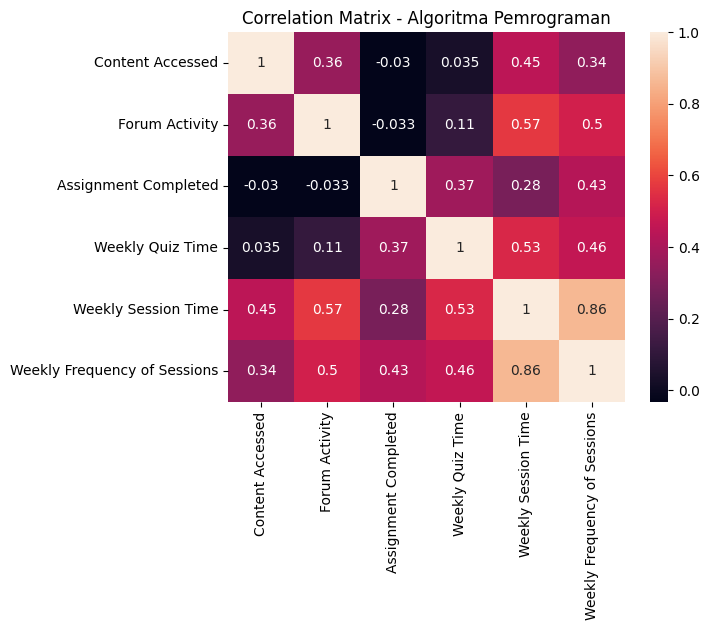

In [121]:
met = metrics.drop(columns=['User ID'])

sns.heatmap(met.corr(), annot=True)
plt.title('Correlation Matrix - Algoritma Pemrograman')
plt.show()

In [122]:
metrics

,User ID,Content Accessed,Forum Activity,Assignment Completed,Weekly Quiz Time,Weekly Session Time,Weekly Frequency of Sessions
0,1,0.0000,3.0000,3.00,14.4259,16.5500,2.7500
1,2,3.3750,3.5000,3.00,55.6000,30.8125,3.6250
2,3,0.0000,2.0000,0.00,0.0000,3.0000,1.0000
3,4,1.5000,4.0000,0.00,21.5000,1.5000,1.5000
4,5,2.6667,0.0000,0.00,0.0000,6.8000,1.2000
5,6,4.5000,17.0000,0.00,24.2000,32.2500,3.7500
6,7,5.4000,3.6667,3.00,42.8333,20.4000,3.3000
7,8,5.3000,4.3333,3.00,41.7500,35.7059,4.8824
8,9,2.5000,2.0000,3.00,59.6667,13.2000,2.7333
9,10,4.5000,5.3333,3.00,0.0000,10.1429,1.5714


In [123]:
X = metrics.drop(["User ID", "Weekly Frequency of Sessions"], axis=1).fillna(0)

X_scaled = StandardScaler().fit_transform(X)

### Y 3 Kluster

In [124]:
y_3_kluster = KMeans(n_clusters=3, random_state=42).fit_predict(X)

print(y_3_kluster)

# Mapping: class 1 -> class 0, class 2 -> class 1, class 0 -> class 2
new_labels = np.zeros_like(y_3_kluster)
new_labels[y_3_kluster == 1] = 0
new_labels[y_3_kluster == 2] = 1
new_labels[y_3_kluster == 0] = 2

print(new_labels)

[1 0 1 1 1 2 2 2 0 1 0 2 1 1 1 2 2 1 1 1 0 2 1 2]
[0 2 0 0 0 1 1 1 2 0 2 1 0 0 0 1 1 0 0 0 2 1 0 1]


## Pemodelan Machine Learning Decision Tree

In [125]:
metrics['cluster_3'] = new_labels
metrics.drop(columns=['Weekly Frequency of Sessions'], inplace=True)

metrics

,User ID,Content Accessed,Forum Activity,Assignment Completed,Weekly Quiz Time,Weekly Session Time,cluster_3
0,1,0.0000,3.0000,3.00,14.4259,16.5500,0
1,2,3.3750,3.5000,3.00,55.6000,30.8125,2
2,3,0.0000,2.0000,0.00,0.0000,3.0000,0
3,4,1.5000,4.0000,0.00,21.5000,1.5000,0
4,5,2.6667,0.0000,0.00,0.0000,6.8000,0
5,6,4.5000,17.0000,0.00,24.2000,32.2500,1
6,7,5.4000,3.6667,3.00,42.8333,20.4000,1
7,8,5.3000,4.3333,3.00,41.7500,35.7059,1
8,9,2.5000,2.0000,3.00,59.6667,13.2000,2
9,10,4.5000,5.3333,3.00,0.0000,10.1429,0


### Visualisasi Data

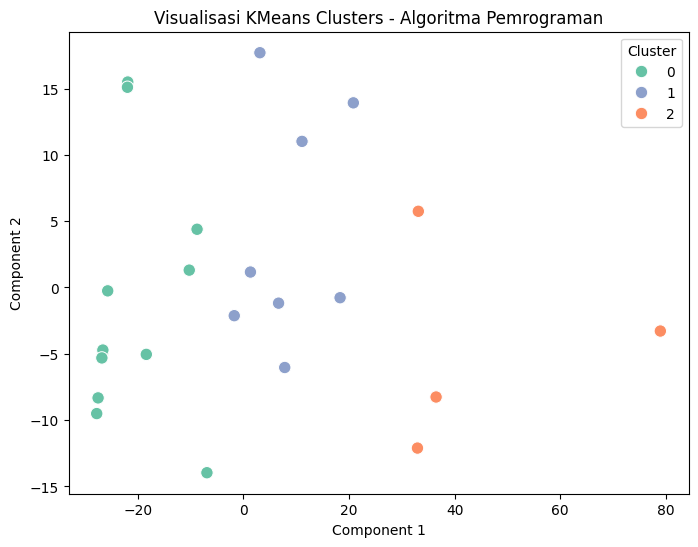

In [126]:
from sklearn.decomposition import PCA

# Pilih kolom X
X = metrics[['Content Accessed', 'Forum Activity', 'Assignment Completed',
        'Weekly Quiz Time', 'Weekly Session Time']]

# PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Buat dataframe hasil PCA
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = metrics['cluster_3'].astype(str)  # ubah jadi string untuk hue di plot

# Visualisasi
plt.figure(figsize=(8,6))
scatter = sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=80)

plt.title('Visualisasi KMeans Clusters - Algoritma Pemrograman')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Ambil handles & labels, lalu urutkan sesuai keinginan
handles, labels = scatter.get_legend_handles_labels()

# Buat mapping urutan baru
order = ['0', '1', '2']
# Filter dan urutkan
ordered = [(h, l) for h, l in zip(handles, labels) if l in order]
ordered.sort(key=lambda x: order.index(x[1]))

# Tampilkan legend dengan urutan baru
scatter.legend(handles=[h for h, l in ordered], labels=[l for h, l in ordered], title='Cluster')

plt.show()

In [127]:
metrics['Tingkat Motivasi'] = metrics['cluster_3'].replace({
    0: 'Rendah',
    1: 'Sedang',
    2: 'Tinggi'
})

['Rendah' 'Tinggi' 'Sedang']


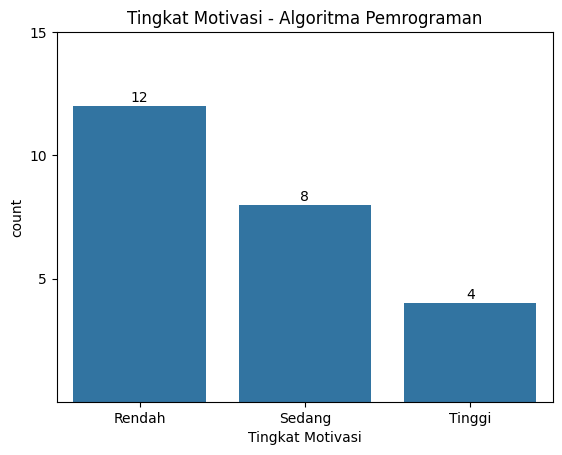

In [128]:
# Cek urutan unik kategorinya dulu
print(metrics['Tingkat Motivasi'].unique())
order = ['Rendah', 'Sedang', 'Tinggi']

# Plotting countplot dengan urutan baru
ax = sns.countplot(x='Tingkat Motivasi', data=metrics, order=order)
plt.title('Tingkat Motivasi - Algoritma Pemrograman')

# Menambahkan angka di atas setiap bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.05,
            f'{height:.0f}', ha='center', va='bottom')

# Menampilkan angka 5, 10, 15 di sumbu y
plt.yticks([5, 10, 15])

plt.show()

### Base Model

Train-test split data, 80% train - 20% test

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [130]:
X = metrics.drop(columns=['cluster_3', 'Tingkat Motivasi'])
y = metrics['cluster_3']

X_train, X_test, y_train, y_test = train_test_split(
    X,            # Features
    y,            # Target variable
    test_size=0.2, 
    random_state=6, 
    stratify=y_3_kluster
)

Cross-validation scores: [0.85714286 1.         0.83333333]
Average CV score: 0.8968253968253969


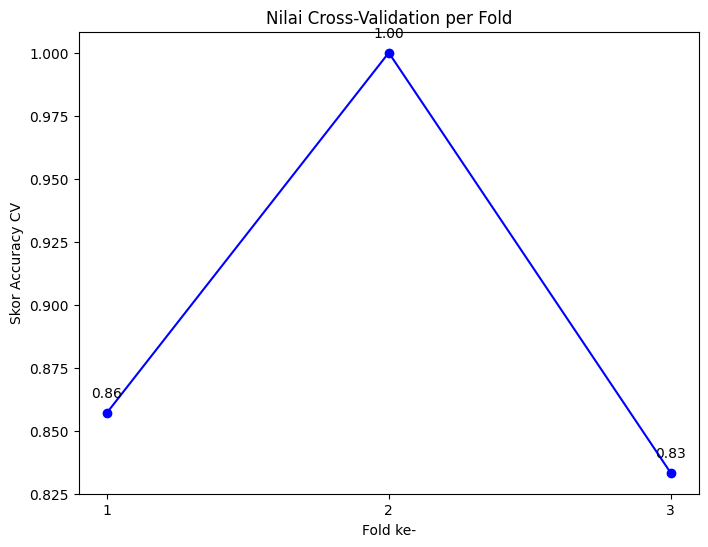

In [131]:
dt = DecisionTreeClassifier(random_state=6)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=6)

# Menghitung cross-validation score dengan stratified k-fold
cv_scores = cross_val_score(dt, X_train, y_train, cv=skf)

# Menampilkan hasil cross-validation
print(f'Cross-validation scores: {cv_scores}')
print(f'Average CV score: {cv_scores.mean()}')

# Plot nilai CV dengan line plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', color='b')

# Menambahkan anotasi untuk setiap fold
for i, score in enumerate(cv_scores, 1):
    plt.text(i, score + 0.005, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Nilai Cross-Validation per Fold')
plt.xlabel('Fold ke-')
plt.ylabel('Skor Accuracy CV')
plt.xticks(np.arange(1, len(cv_scores) + 1))
plt.show()

In [132]:
# Melatih model pada data training
dt.fit(X_train, y_train)

# Memprediksi menggunakan data pengujian
y_pred = dt.predict(X_test)

# Menghitung akurasi pada data testing
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data: {accuracy}')

from sklearn.metrics import classification_report

y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred, digits=4)) 

Accuracy on test data: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2
           2     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         5
   macro avg     1.0000    1.0000    1.0000         5
weighted avg     1.0000    1.0000    1.0000         5



### Hyperparameter Tuning

In [133]:
from sklearn.model_selection import GridSearchCV

# Inisialisasi model dasar
dt_tune = DecisionTreeClassifier(random_state=6)

# Buat grid hyperparameter
param_grid = {
    'max_depth': [None, 3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Inisialisasi StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=6)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_tune,
    param_grid=param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

# Jalankan grid search
grid_search.fit(X_train, y_train)

# Hasil terbaik
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluasi ulang dengan model terbaik
best_dt = grid_search.best_estimator_

# Prediksi di test data
y_pred = best_dt.predict(X_test)

# Hitung akurasi
from sklearn.metrics import accuracy_score, classification_report

accuracy_after = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data: {accuracy_after}')
print(classification_report(y_test, y_pred, digits=4))


Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.8968253968253969
Accuracy on test data: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2
           2     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         5
   macro avg     1.0000    1.0000    1.0000         5
weighted avg     1.0000    1.0000    1.0000         5



In [134]:
print("Detail Hasil dari Setiap Kombinasi Hyperparameter:")
results_df = pd.DataFrame(grid_search.cv_results_)

relevant_columns = ["params", "mean_test_score", "std_test_score", "rank_test_score"]
results_df = results_df[relevant_columns].sort_values(by="rank_test_score")
print(results_df.to_string())

Detail Hasil dari Setiap Kombinasi Hyperparameter:
                                                                                           params  mean_test_score  std_test_score  rank_test_score
0         {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}         0.896825        0.073600                1
1         {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}         0.896825        0.073600                1
5         {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}         0.896825        0.073600                1
4         {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}         0.896825        0.073600                1
20           {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}         0.896825        0.073600                1
21           {'criterion': 'gini', 'max_depth': 3, 'min_sampl

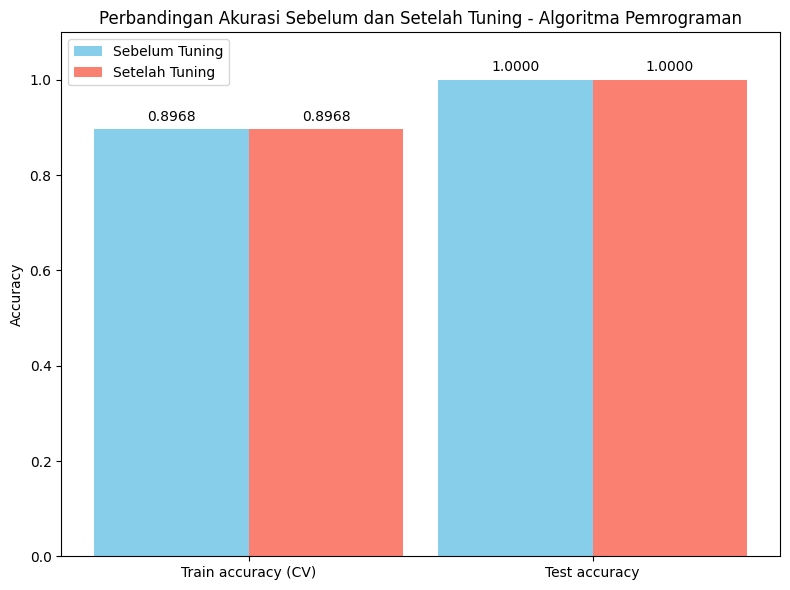

In [135]:
# Visualisasi
labels = ['Train accuracy (CV)', 'Test accuracy']
before = [np.mean(cv_scores), accuracy]
after = [grid_search.best_score_, accuracy_after]

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, before, width, label='Sebelum Tuning', color='skyblue')
rects2 = ax.bar(x + width/2, after, width, label='Setelah Tuning', color='salmon')

ax.set_ylabel('Accuracy')

# Naikkan batas atas sumbu y agar label tidak ketimpa
max_height = max(max(before), max(after))
ax.set_ylim(0, max_height + 0.1)

ax.set_title('Perbandingan Akurasi Sebelum dan Setelah Tuning - Algoritma Pemrograman')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Tampilkan nilai di atas bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',  # tampilkan 4 angka di belakang koma
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 4), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


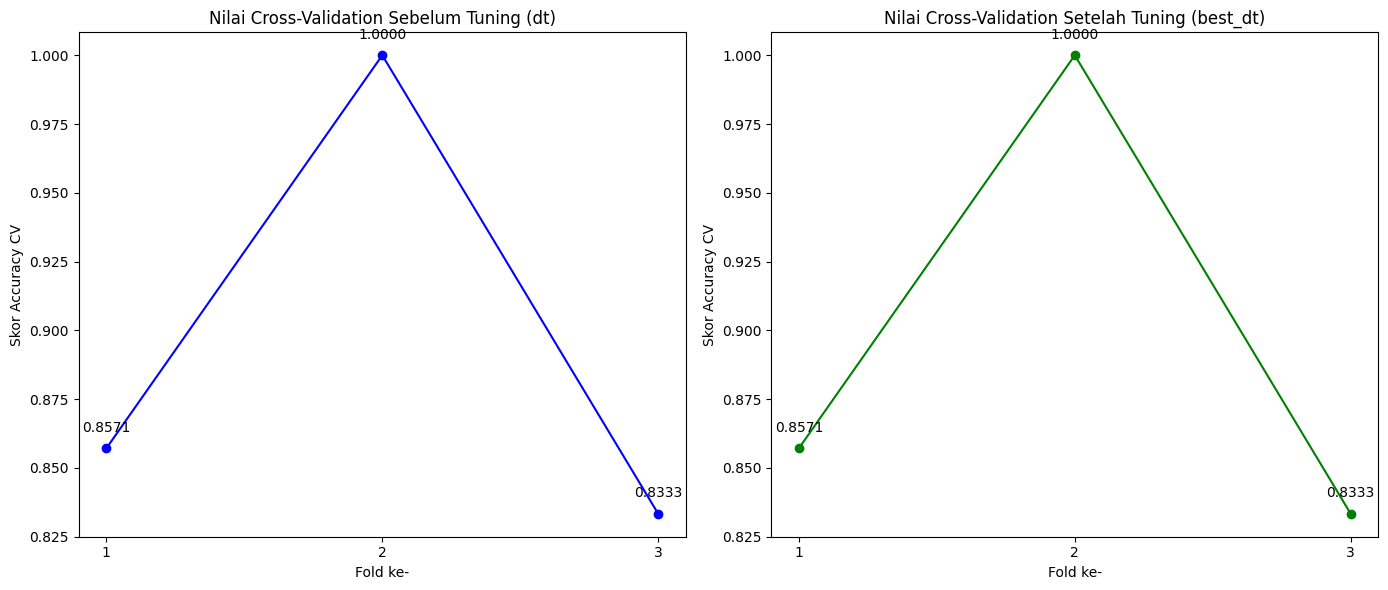

In [136]:
# StratifiedKFold untuk cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=6)

# Menghitung cross-validation score dengan dt (sebelum tuning)
cv_scores_before = cross_val_score(dt, X_train, y_train, cv=skf)

# Menghitung cross-validation score dengan best_dt (setelah tuning)
cv_scores_after = cross_val_score(best_dt, X_train, y_train, cv=skf)

# Membuat side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot untuk sebelum tuning
axes[0].plot(np.arange(1, len(cv_scores_before) + 1), cv_scores_before, marker='o', linestyle='-', color='b')
for i, score in enumerate(cv_scores_before, 1):
    axes[0].text(i, score + 0.005, f'{score:.4f}', ha='center', va='bottom', fontsize=10)
axes[0].set_title('Nilai Cross-Validation Sebelum Tuning (dt)')
axes[0].set_xlabel('Fold ke-')
axes[0].set_ylabel('Skor Accuracy CV')
axes[0].set_xticks(np.arange(1, len(cv_scores_before) + 1))

# Plot untuk setelah tuning
axes[1].plot(np.arange(1, len(cv_scores_after) + 1), cv_scores_after, marker='o', linestyle='-', color='g')
for i, score in enumerate(cv_scores_after, 1):
    axes[1].text(i, score + 0.005, f'{score:.4f}', ha='center', va='bottom', fontsize=10)
axes[1].set_title('Nilai Cross-Validation Setelah Tuning (best_dt)')
axes[1].set_xlabel('Fold ke-')
axes[1].set_ylabel('Skor Accuracy CV')
axes[1].set_xticks(np.arange(1, len(cv_scores_after) + 1))

# Menampilkan kedua plot
plt.tight_layout()
plt.show()

### SHAP Values

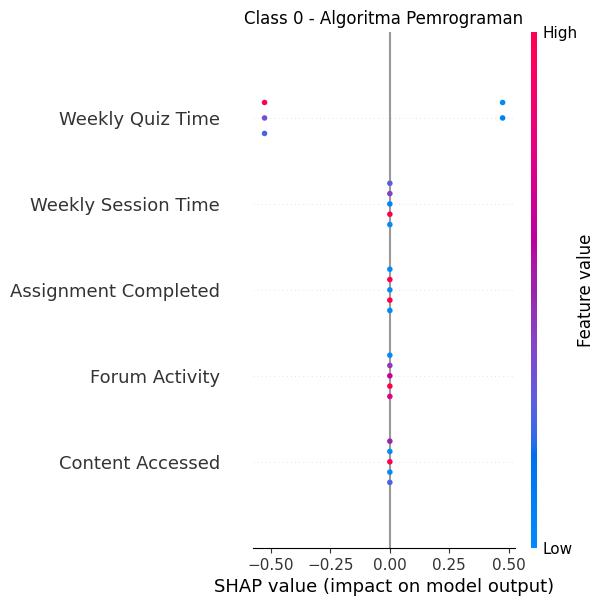

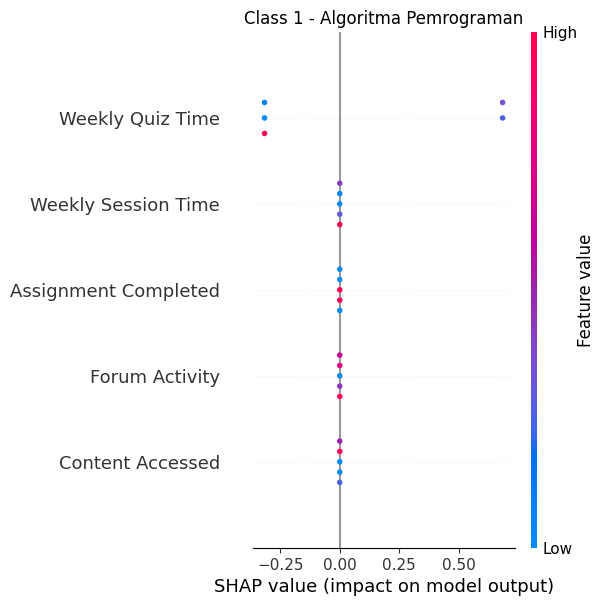

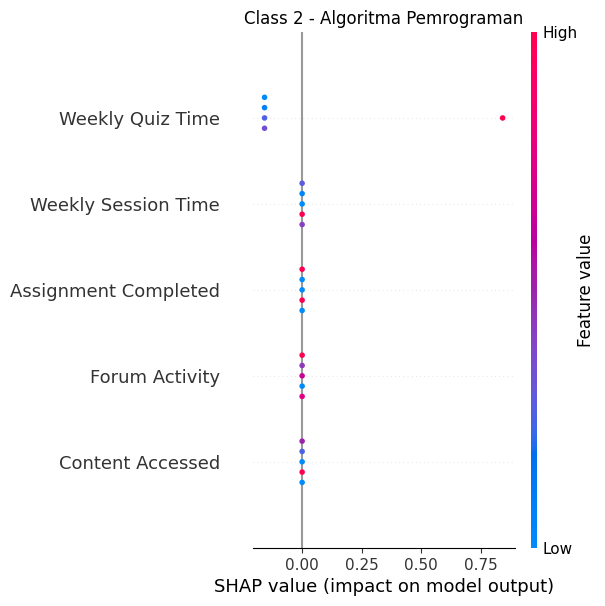

In [137]:
import shap

# Compute SHAP values for the trained decision tree
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_test)

selected_features = ["Content Accessed", "Forum Activity", "Assignment Completed", 
                     "Weekly Quiz Time", "Weekly Session Time"]

X_test_selected = X_test[selected_features]

# Dapatkan indeks fitur terpilih sesuai urutan di X_test.columns
selected_idx = [X_test.columns.get_loc(f) for f in selected_features]

# Subset shap_values untuk fitur tersebut
shap_values_selected_0 = shap_values[:, selected_idx, 0]
shap_values_selected_1 = shap_values[:, selected_idx, 1]
shap_values_selected_2 = shap_values[:, selected_idx, 2]

# Plot - tambah plot_size
shap.summary_plot(shap_values_selected_0, X_test_selected, show=False, plot_size=(6,6))
plt.title("Class 0 - Algoritma Pemrograman")
plt.show()

shap.summary_plot(shap_values_selected_1, X_test_selected, show=False, plot_size=(6,6))
plt.title("Class 1 - Algoritma Pemrograman")
plt.show()

shap.summary_plot(shap_values_selected_2, X_test_selected, show=False, plot_size=(6,6))
plt.title("Class 2 - Algoritma Pemrograman")
plt.show()

### Confussion Matrix

[[2 0 0]
 [0 2 0]
 [0 0 1]]


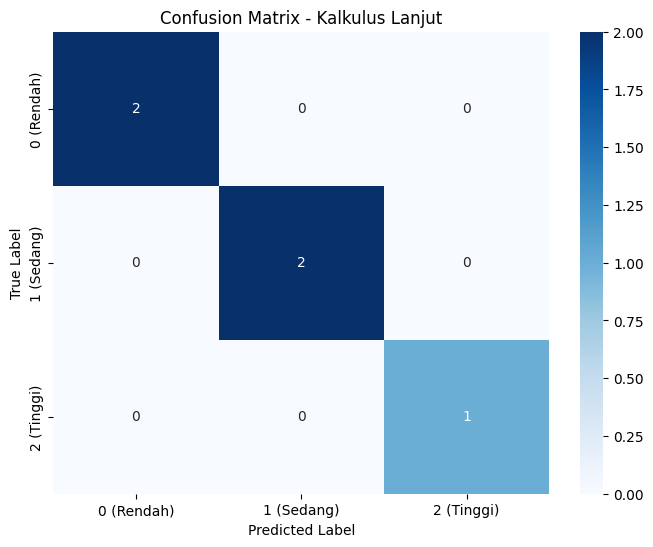

In [138]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, best_dt.predict(X_test))
print(cm)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0 (Rendah)', '1 (Sedang)', '2 (Tinggi)'], 
            yticklabels=['0 (Rendah)', '1 (Sedang)', '2 (Tinggi)'])
plt.title('Confusion Matrix - Kalkulus Lanjut')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()